In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout, GaussianDropout
from tensorflow.keras.layers import BatchNormalization, Activation
from tensorflow.python.keras.layers.advanced_activations import LeakyReLU
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import sys
import numpy as np

C:\Users\ragja\Anaconda3\envs\test\lib\site-packages\tensorflow\python\framework\dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\ragja\Anaconda3\envs\test\lib\site-packages\tensorflow\python\framework\dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\ragja\Anaconda3\envs\test\lib\site-packages\tensorflow\python\framework\dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\ragja\Anaconda3\envs\test\lib\site-packages\tensorflow\python\frame

In [2]:
class SynthDataset():
    
    def __init__(self, N, x_dim=100, num_clusters=10, seed=1234):
        
        np.random.seed(seed)
        
        self.x_dim = x_dim
        self.N = N
        self.true_z_dim = 2
        # generate synthetic data
        self.Xs = []
        for _ in range(num_clusters):
            cluster_mean = np.random.randn(self.true_z_dim) * 5 # to make them more spread
            A = np.random.randn(self.x_dim, self.true_z_dim) * 5
            X = np.dot(np.random.randn(self.N // num_clusters, self.true_z_dim) + cluster_mean,
                       A.T)
            self.Xs.append(X)
        X_raw = np.concatenate(self.Xs)
        self.X = (X_raw - X_raw.mean(0)) / (X_raw.std(0))
        print(self.X.shape)
        
        
    def next_batch(self, batch_size):

        rand_idx = np.random.choice(range(self.N), size=(batch_size,), replace=False)
        return self.X[rand_idx]

synth_d = SynthDataset(10000)

(10000, 100)


In [3]:
def plot_figures(data_trans_real,data_trans_fake,size):    
    xmin1 = np.min(data_trans_real[:, 0]) - 1.0
    xmax1 = np.max(data_trans_real[:, 0]) + 1.0
    xmin2 = np.min(data_trans_real[:, 1]) - 1.0
    xmax2 = np.max(data_trans_real[:, 1]) + 1.0

    fig = plt.figure(figsize=(size,size))
    ax1 = fig.add_subplot(221)
    ax2 = fig.add_subplot(222, sharex=ax1, sharey=ax1)

    ax1.plot(data_trans_real[:, 0], data_trans_real[:, 1], '.r')
    ax1.set_xlim([xmin1, xmax1]); ax1.set_ylim([xmin2, xmax2])
    ax1.set_aspect('equal', adjustable='box')

    ax2.plot(data_trans_fake[:, 0], data_trans_fake[:, 1], '.g')
    ax2.set_xlim([xmin1, xmax1]); ax2.set_ylim([xmin2, xmax2])
    ax2.set_aspect('equal', adjustable='box')
    return fig

In [22]:
class GAN():
    def __init__(self):
        self.N = 10000
        self.img_rows = 28
        self.img_cols = 28
        self.channels = 1
        self.img_shape = 100
        self.latent_dim = 100
        self.dropout = 0.99
        self.dropout1 = 0.2
        lengthscale = 1e-2
        self.reg = lengthscale**2 * (1 - self.dropout) / (2. * self.N )
        
        optimizer = Adam(0.0002, 0.5)
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
        self.generator = self.build_generator()

        z = Input(shape=(self.latent_dim,))
        img = self.generator(z)

        self.discriminator.trainable = False
        validity = self.discriminator(img)
        self.combined = Model(z, validity)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)
        
    def build_generator(self):        
        noise = Input(shape=(self.latent_dim,))        
        model = Dense(256, activation='relu', kernel_regularizer=l2(self.reg))(noise)
        model = Dropout(self.dropout1)(model, training=True)
        model = Dense(512, activation='relu', kernel_regularizer=l2(self.reg))(model)
        model = Dropout(self.dropout)(model, training=True)
        model = Dense(1024, activation='relu', kernel_regularizer=l2(self.reg))(model)
        model = Dropout(self.dropout)(model, training=True)
        output = Dense(np.prod(self.img_shape), kernel_regularizer=l2(self.reg))(model)
        return Model(noise, output)
    
    def build_discriminator(self):
        img = Input(shape=(self.img_shape,))
        model = Flatten(input_shape=(self.img_shape,))(img)
        model = Dense(512, activation='relu', kernel_regularizer=l2(self.reg))(model)
        model = Dropout(self.dropout1)(model, training=True)
        model = Dense(256, activation='relu', kernel_regularizer=l2(self.reg))(model)
        model = Dropout(self.dropout)(model, training=True)
        output = Dense(1, activation='sigmoid')(model)        
        return Model(img, output)
    
    def train(self, epochs, batch_size=128, sample_interval=50):
        X_train = synth_d.X
        #X_train = np.expand_dims(X_train, axis=3)
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))
        for epoch in range(epochs):
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs = X_train[idx]
            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
            gen_imgs = self.generator.predict(noise)
            d_loss_real = self.discriminator.train_on_batch(imgs, valid)
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
            g_loss = self.combined.train_on_batch(noise, valid)
            if epoch % sample_interval == 0:
               self.sample_images(epoch,batch_size,imgs,gen_imgs)
               print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))
            
    def sample_images(self, epoch, batch_size,imgs,gen_imgs):
        pca = PCA(2)
        data_trans_real = pca.fit_transform(imgs)    
        data_trans_fake = pca.transform(gen_imgs)
        fig=plot_figures(data_trans_real,data_trans_fake,10)
        fig.savefig("images/%d.png" % epoch)
        plt.show()
        plt.close()
    
    def predict(self, no_samples):
        noise = np.random.normal(0, 1, (10000, self.latent_dim))
        for k in range(no_samples):
            gen_imgs = self.generator.predict(noise)
            pca = PCA(2)
            data_trans_real = pca.fit_transform(synth_d.X)    
            data_trans_fake = pca.transform(gen_imgs)
            fig=plot_figures(data_trans_real,data_trans_fake,10)
            fig.savefig("images/%d.png" % k)
            plt.show()
            plt.close()
        

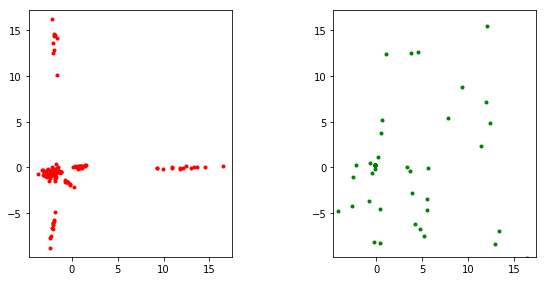

0 [D loss: 2.978657, acc.: 41.02%] [G loss: 3.493990]


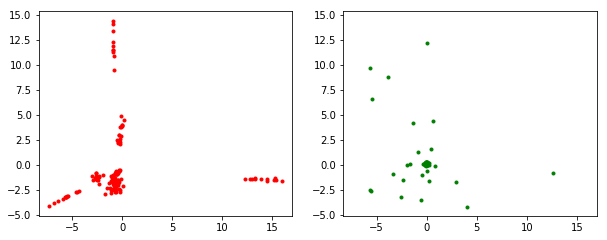

1000 [D loss: 0.658347, acc.: 53.91%] [G loss: 0.758175]


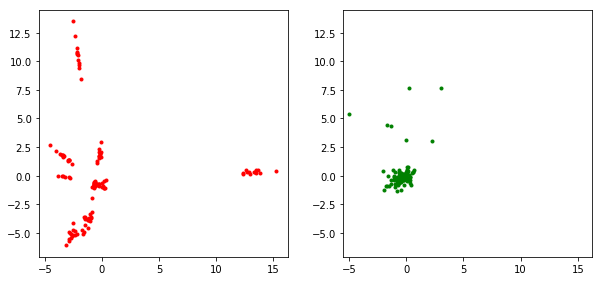

2000 [D loss: 0.607664, acc.: 60.94%] [G loss: 1.565004]


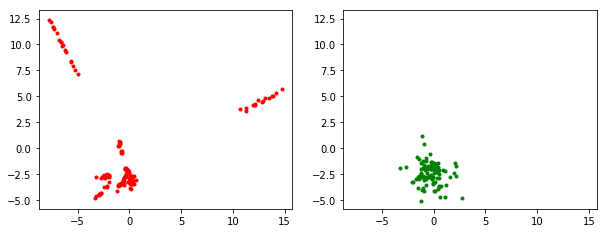

3000 [D loss: 0.427800, acc.: 80.47%] [G loss: 2.752039]


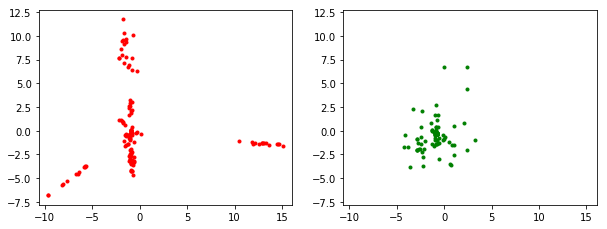

4000 [D loss: 0.477857, acc.: 80.08%] [G loss: 2.781776]


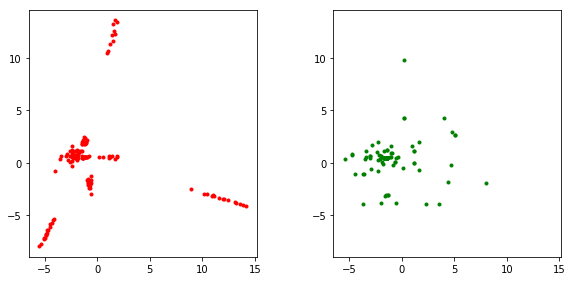

5000 [D loss: 0.490362, acc.: 79.69%] [G loss: 3.185707]


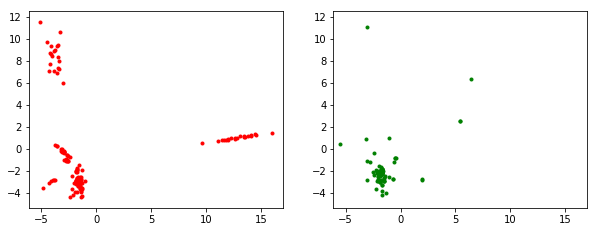

6000 [D loss: 0.446459, acc.: 77.73%] [G loss: 3.271324]


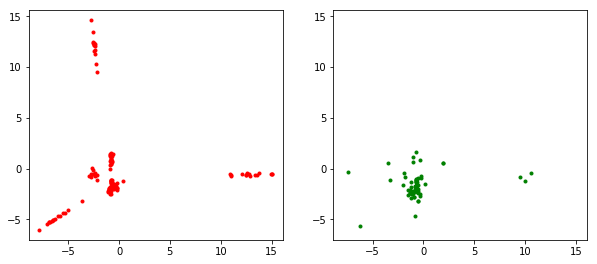

7000 [D loss: 0.482067, acc.: 75.39%] [G loss: 2.824274]


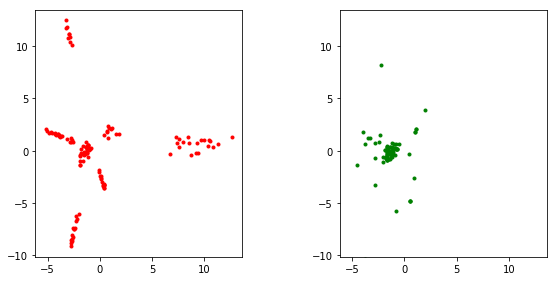

8000 [D loss: 0.529504, acc.: 69.92%] [G loss: 2.322158]


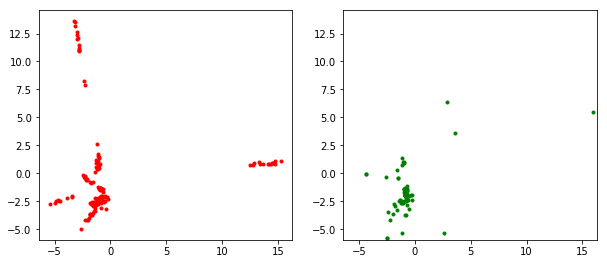

9000 [D loss: 0.552407, acc.: 73.05%] [G loss: 2.912267]


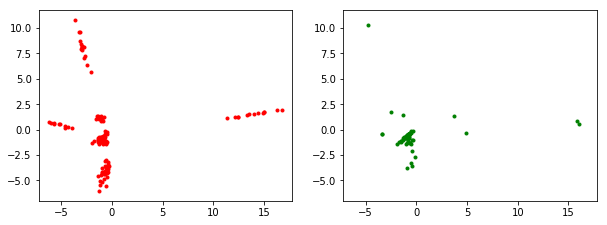

10000 [D loss: 0.513278, acc.: 70.70%] [G loss: 2.419573]


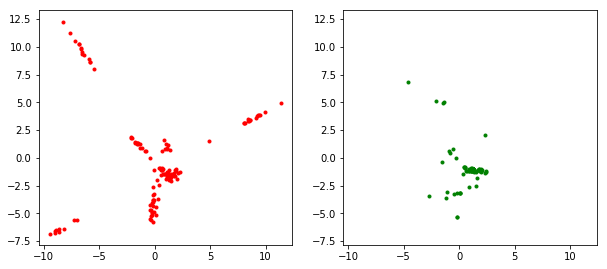

11000 [D loss: 0.421789, acc.: 76.17%] [G loss: 2.781143]


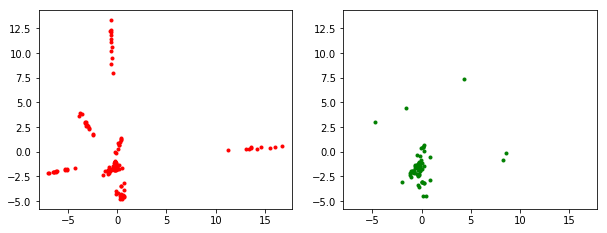

12000 [D loss: 0.492696, acc.: 69.14%] [G loss: 1.706643]


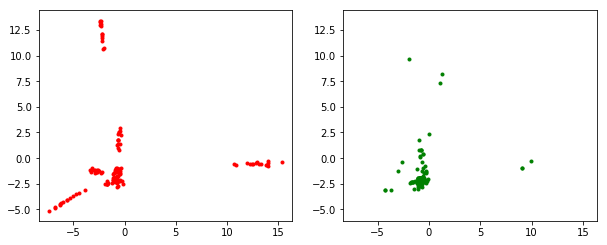

13000 [D loss: 0.452227, acc.: 78.52%] [G loss: 2.183113]


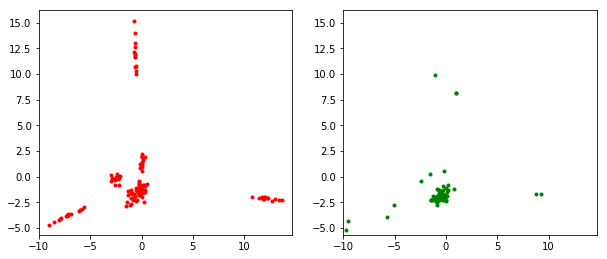

14000 [D loss: 0.495292, acc.: 74.61%] [G loss: 2.205091]


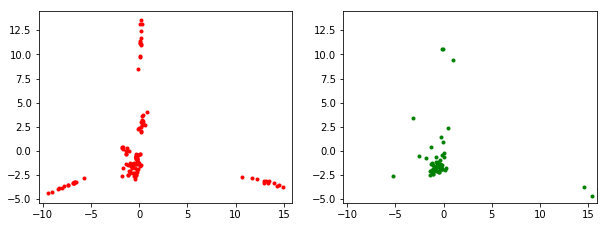

15000 [D loss: 0.474219, acc.: 78.12%] [G loss: 2.735661]


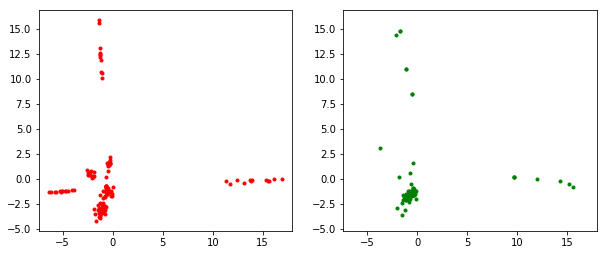

16000 [D loss: 0.498612, acc.: 73.83%] [G loss: 2.510873]


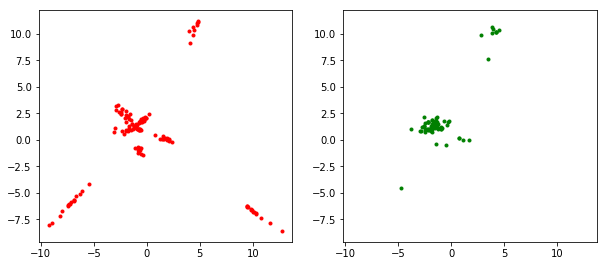

17000 [D loss: 0.420447, acc.: 78.12%] [G loss: 2.351233]


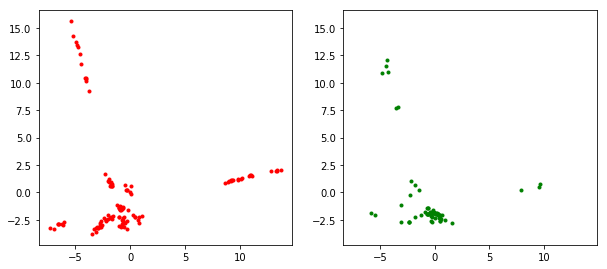

18000 [D loss: 0.398082, acc.: 79.30%] [G loss: 2.873990]


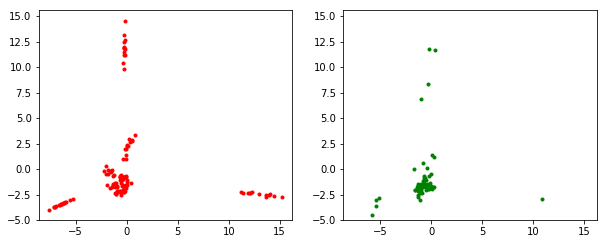

19000 [D loss: 0.348513, acc.: 82.42%] [G loss: 2.822282]


In [23]:
gan = GAN()
gan.train(epochs=20000, batch_size=128, sample_interval=1000)

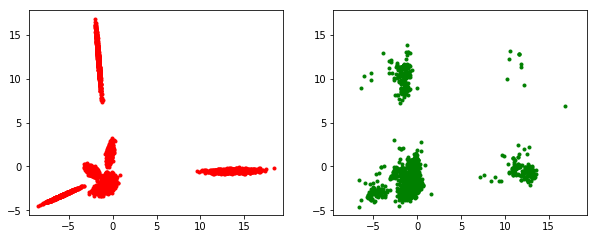

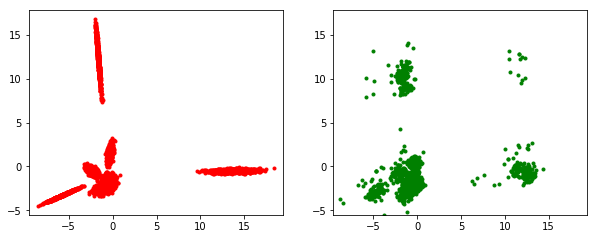

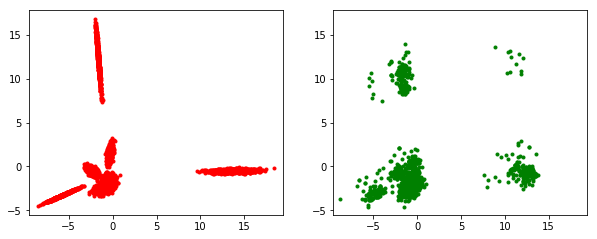

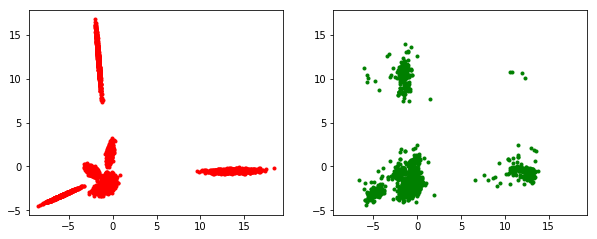

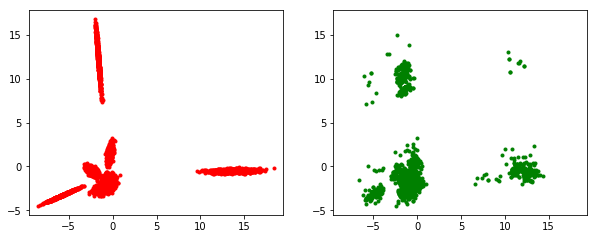

In [24]:
gan.predict(5)